In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import gensim
import nltk
import spacy
import re
import spacy
import matplotlib.pyplot as plt
import string
import math

from ydata_profiling import ProfileReport
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk import tokenize
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as MSE


from spacy import displacy
from transformers import pipeline
from itertools import product

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


/kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv
/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv
/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv
/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv
/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv


In [2]:
prompts_test = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv")
prompts_train = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv")
sample_submission = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv")
summaries_test = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv")
summaries_train = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv")

# **Data Understanding**

In [3]:
prompts_test.head()

prompt_id prompt_question     prompt_title       prompt_text
0    abc123    Summarize...  Example Title 1  Heading\nText...
1    def789    Summarize...  Example Title 2  Heading\nText...

In [4]:
prompts_train.head()

prompt_id                                    prompt_question  \
0    39c16e  Summarize at least 3 elements of an ideal trag...   
1    3b9047  In complete sentences, summarize the structure...   
2    814d6b  Summarize how the Third Wave developed over su...   
3    ebad26  Summarize the various ways the factory would u...   

                prompt_title  \
0                 On Tragedy   
1  Egyptian Social Structure   
2             The Third Wave   
3    Excerpt from The Jungle   

                                         prompt_text  
0  Chapter 13 \r\nAs the sequel to what has alrea...  
1  Egyptian society was structured like a pyramid...  
2  Background \r\nThe Third Wave experiment took ...  
3  With one member trimming beef in a cannery, an...

In [5]:
sample_submission.head()

student_id  content  wording
0  000000ffffff      0.0      0.0
1  111111eeeeee      0.0      0.0
2  222222cccccc      0.0      0.0
3  333333dddddd      0.0      0.0

In [6]:
summaries_test.head()

student_id prompt_id            text
0  000000ffffff    abc123  Example text 1
1  111111eeeeee    def789  Example text 2
2  222222cccccc    abc123  Example text 3
3  333333dddddd    def789  Example text 4

In [7]:
summaries_train.head()

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0020ae56ffbf    ebad26  They would rub it up with soda to make the sme...   
2  004e978e639e    3b9047  In Egypt, there were many occupations and soci...   
3  005ab0199905    3b9047  The highest class was Pharaohs these people we...   
4  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   

    content   wording  
0  0.205683  0.380538  
1 -0.548304  0.506755  
2  3.128928  4.231226  
3 -0.210614 -0.471415  
4  3.272894  3.219757

In [8]:
prompts_test.dtypes

prompt_id          object
prompt_question    object
prompt_title       object
prompt_text        object
dtype: object

In [9]:
prompts_train.dtypes

prompt_id          object
prompt_question    object
prompt_title       object
prompt_text        object
dtype: object

In [10]:
sample_submission.dtypes

student_id     object
content       float64
wording       float64
dtype: object

In [11]:
summaries_test.dtypes

student_id    object
prompt_id     object
text          object
dtype: object

In [12]:
summaries_train.dtypes

student_id     object
prompt_id      object
text           object
content       float64
wording       float64
dtype: object

In [13]:
train_df = prompts_train.merge(summaries_train, on='prompt_id', how='inner')
train_df.head()

prompt_id                                    prompt_question prompt_title  \
0    39c16e  Summarize at least 3 elements of an ideal trag...   On Tragedy   
1    39c16e  Summarize at least 3 elements of an ideal trag...   On Tragedy   
2    39c16e  Summarize at least 3 elements of an ideal trag...   On Tragedy   
3    39c16e  Summarize at least 3 elements of an ideal trag...   On Tragedy   
4    39c16e  Summarize at least 3 elements of an ideal trag...   On Tragedy   

                                         prompt_text    student_id  \
0  Chapter 13 \r\nAs the sequel to what has alrea...  00791789cc1f   
1  Chapter 13 \r\nAs the sequel to what has alrea...  0086ef22de8f   
2  Chapter 13 \r\nAs the sequel to what has alrea...  0094589c7a22   
3  Chapter 13 \r\nAs the sequel to what has alrea...  00cd5736026a   
4  Chapter 13 \r\nAs the sequel to what has alrea...  00d98b8ff756   

                                                text   content   wording  
0  1 element of an ideal tragedy is that it shoul... -0.210614 -0.471415  
1  The three elements of an ideal tragedy are:  H... -0.970237 -0.417058  
2  Aristotle states that an ideal tragedy should ... -0.387791 -0.584181  
3  One element of an Ideal tragedy is having a co...  0.088882 -0.594710  
4  The 3 ideal of tragedy is how complex you need... -0.687288 -0.460886

In [14]:
train_df.shape

(7165, 8)

In [15]:
test_df = prompts_test.merge(summaries_test, on='prompt_id', how='inner')
test_df.head()

prompt_id prompt_question     prompt_title       prompt_text    student_id  \
0    abc123    Summarize...  Example Title 1  Heading\nText...  000000ffffff   
1    abc123    Summarize...  Example Title 1  Heading\nText...  222222cccccc   
2    def789    Summarize...  Example Title 2  Heading\nText...  111111eeeeee   
3    def789    Summarize...  Example Title 2  Heading\nText...  333333dddddd   

             text  
0  Example text 1  
1  Example text 3  
2  Example text 2  
3  Example text 4

In [16]:
test_df.shape

(4, 6)

In [17]:
profile = ProfileReport(train_df, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# We see that content has a high correlation with wording, so it would be useful to study it further

Text(0.5, 1.0, 'Content distribution')

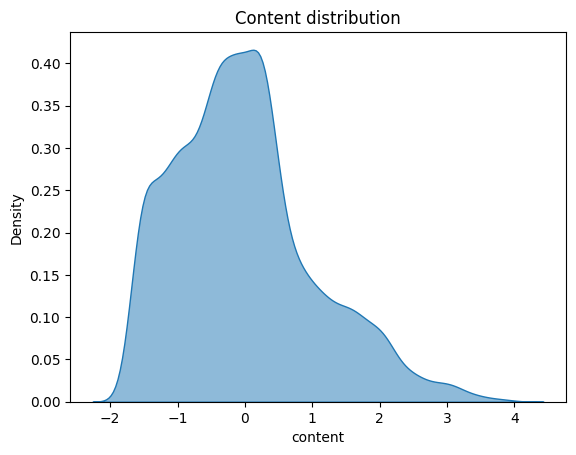

In [18]:
sns.kdeplot(data=train_df, x="content", alpha=.5, fill=True)
plt.title("Content distribution")

Text(0.5, 1.0, 'Wording Score distribution')

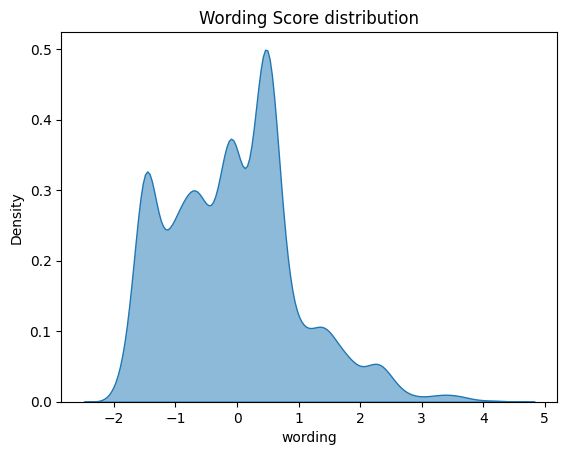

In [19]:
sns.kdeplot(data=train_df, x="wording", alpha=.5, fill=True)
plt.title("Wording Score distribution")

<Axes: xlabel='content', ylabel='wording'>

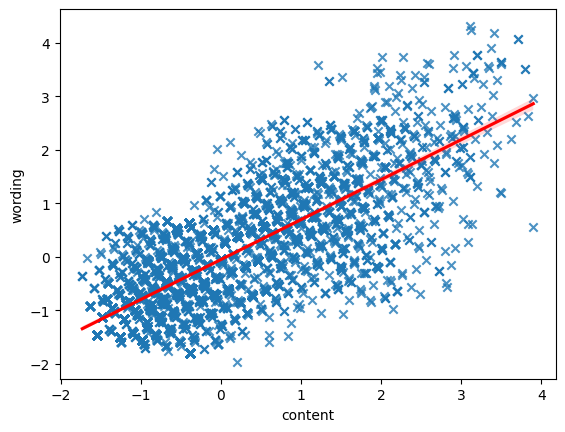

In [20]:
sns.regplot(
    data=train_df, x="content", y="wording",
    ci=99, marker="x", line_kws=dict(color="r"),
)

# **Evaluation**

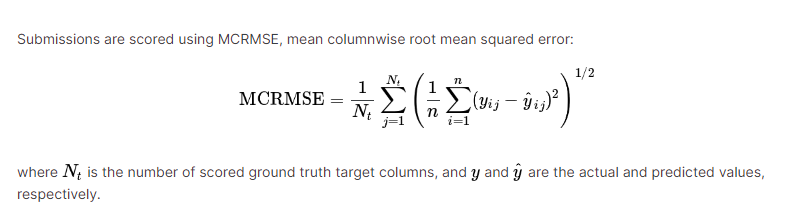

# **Preprocessing**

In [21]:
train_df["is_train"] = True
test_df["is_train"] = False

train_test = pd.concat([train_df, test_df]).reset_index(drop=True)

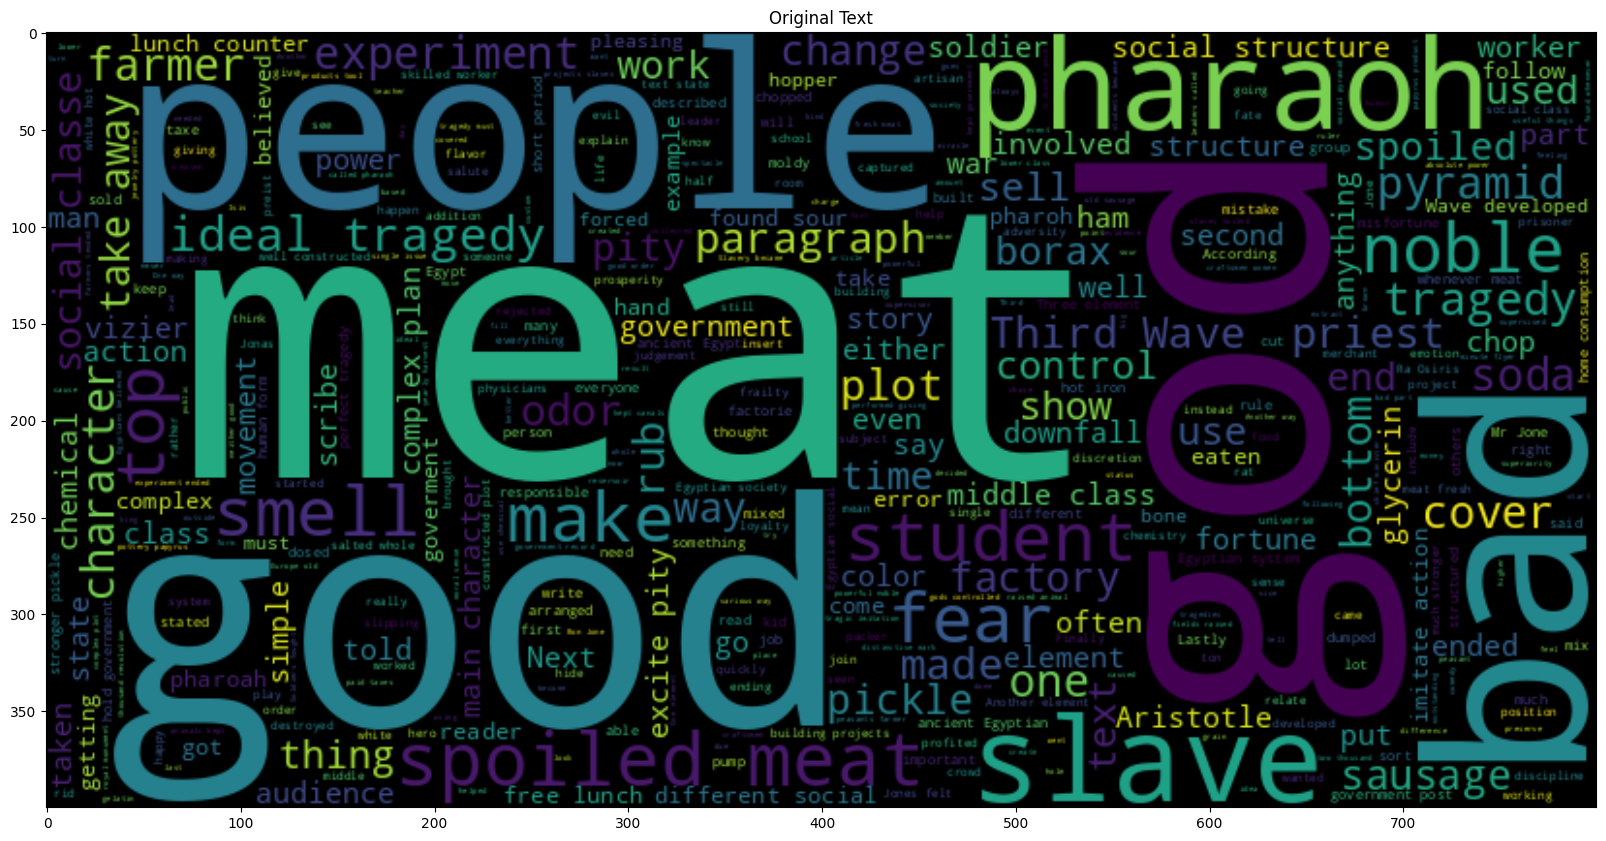

In [22]:
plt.figure(figsize = (20,20)) 
plt.title("Original Text")
wc = WordCloud(max_words = 500 , width = 800 , height = 400).generate(" ".join(train_test['text']))
plt.imshow(wc, interpolation = 'bilinear')

# I decided to look at most frequent words to see what I need to provide during preprocessing.
# I see that I don`t have something like links or special symbols and it is predictable because of type of our texts. So considering it we might only need a punctuation processing

# Hard preprocessing

In [23]:
nltk.download('stopwords')

stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def preprocess_hard(text, join_back=True):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        # Stop Words Cleaning
        if (
            token not in gensim.parsing.preprocessing.STOPWORDS and 
            # len(token) > 2 and 
            token not in stop_words
        ):
            result.append(token)
    if join_back:
        result = " ".join(result)
    return result

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Light preprocessing

In [24]:
def process_light(input):
    if isinstance(input, str):
        input = " ".join(tokenize.sent_tokenize(input))
        input = re.sub(r'[^\w\s.]|\r', '', input)       
        input = collapse_dots(input)
        input = input.strip()
        input = input.lower()
    return input

In [25]:
nltk.download('punkt')

def collapse_dots(input):
    # Collapse sequential dots
    input = re.sub("\.+", ".", input)
    # Collapse dots separated by whitespaces
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", input)
        all_collapsed = input == output
        input = output
    return output

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [26]:
train_test["hard_clean_text"] = train_test['text'].apply(preprocess_hard)
train_test["light_clean_text"] = train_test['text'].apply(process_light)

In [27]:
idx = 10

print(
    f"Before : {train_test['text'].iloc[idx]}\n"
    f"Hard Processing : {train_test['hard_clean_text'].iloc[idx]}\n"
    f"Light Processing : {train_test['light_clean_text'].iloc[idx]}\n"
)

idx = 100

print(
    f"Before : {train_test['text'].iloc[idx]}\n"
    f"Hard Processing : {train_test['hard_clean_text'].iloc[idx]}\n"
    f"Light Processing : {train_test['light_clean_text'].iloc[idx]}\n"
)

Before : Aristotle explains that an ideal tragedy should end dramaticly and not happily.He shows that not ending with a bang does not please the audience. He also explains how the plot should begin with one issue rather than two. Lastly he explains that tragic effect wins.
Hard Processing : aristotle explains ideal tragedy end dramaticly happily shows ending bang audience explains plot begin issue lastly explains tragic effect wins
Light Processing : aristotle explains that an ideal tragedy should end dramaticly and not happily.he shows that not ending with a bang does not please the audience. he also explains how the plot should begin with one issue rather than two. lastly he explains that tragic effect wins.

Before : It should be arranged not on the simple but make it on a complex plan.It should focus on imitating actions which can give pity and fear.It should satisy the moral sense but it shouldn't inspire fear nor pity.
Hard Processing : arranged simple complex plan focus imitatin

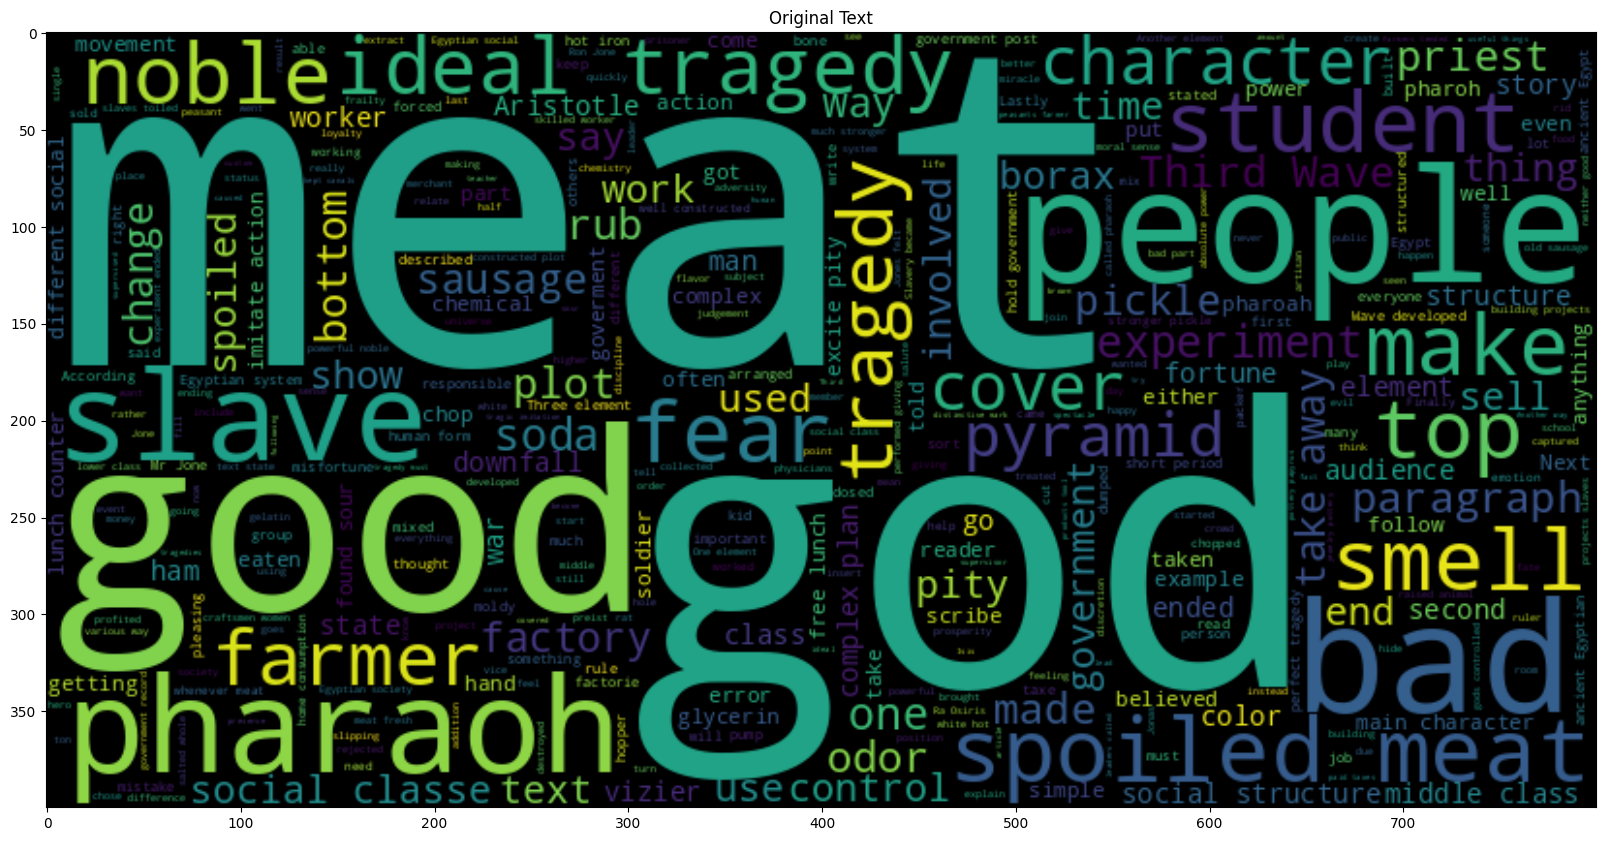

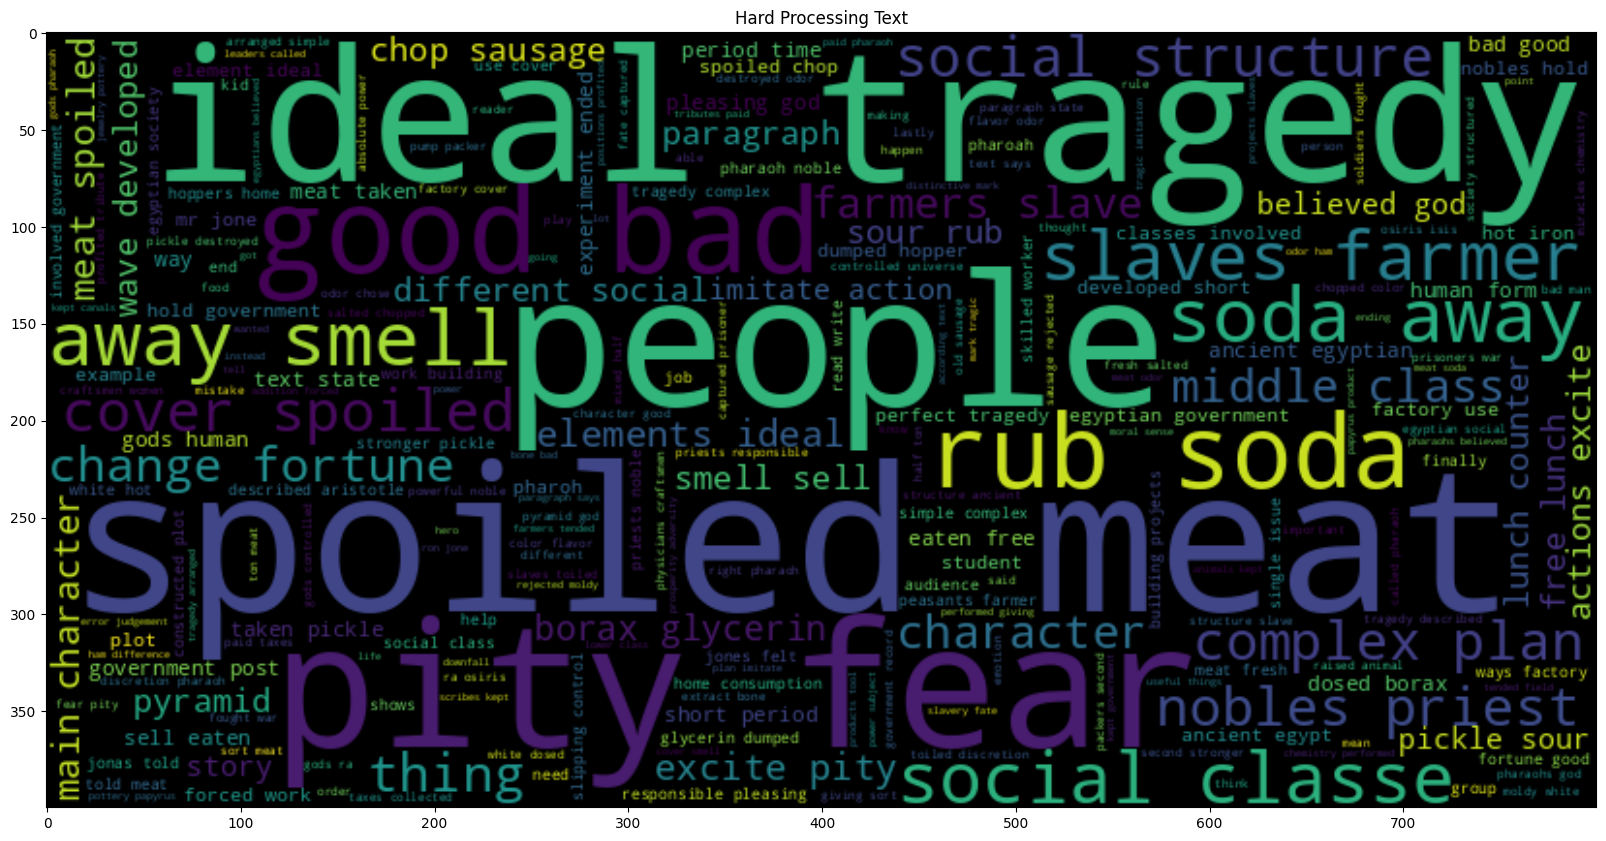

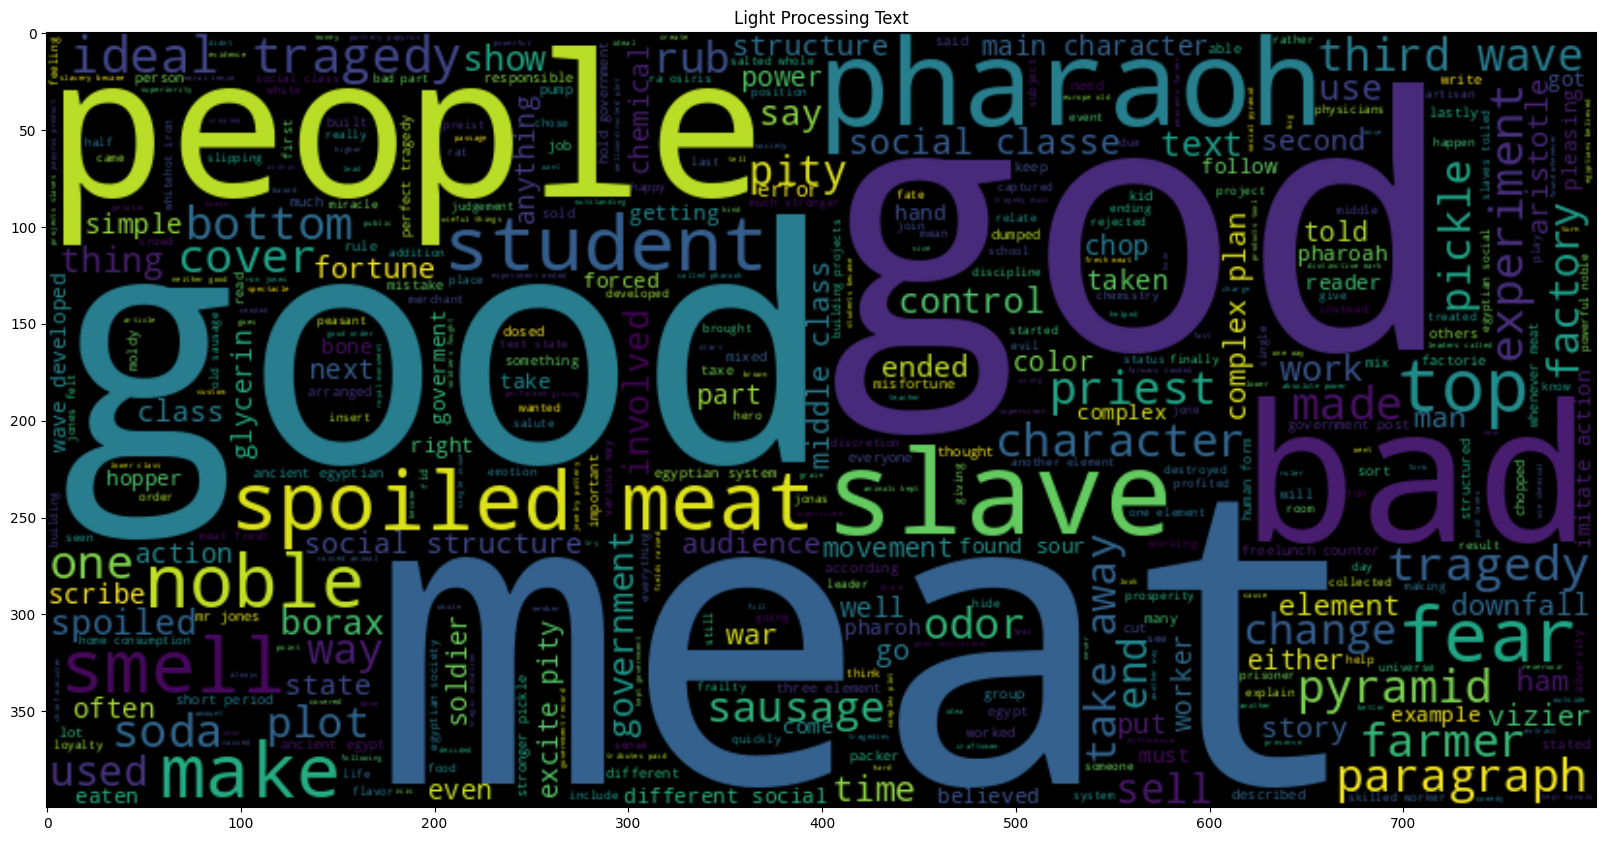

In [28]:
plt.figure(figsize = (20,20)) 
plt.title("Original Text")
wc = WordCloud(max_words = 500 , width = 800 , height = 400).generate(" ".join(train_test['text']))
plt.imshow(wc, interpolation = 'bilinear')

plt.figure(figsize = (20,20)) 
plt.title("Hard Processing Text")
wc = WordCloud(max_words = 500 , width = 800 , height = 400).generate(" ".join(train_test['hard_clean_text']))
plt.imshow(wc, interpolation = 'bilinear')

plt.figure(figsize = (20,20)) 
plt.title("Light Processing Text")
wc = WordCloud(max_words = 500 , width = 800 , height = 400).generate(" ".join(train_test['light_clean_text']))
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

# We probably should avoid hard processing beacause there is a risk that "wording" target may loose from it.

# **Feature Engineering**

In [29]:
train_test["n_symbols"] = train_test["light_clean_text"].apply(len)
train_test["n_words"] = train_test["light_clean_text"].apply(lambda x: len(nltk.tokenize.word_tokenize(x)))
train_test["n_sents"] = train_test["light_clean_text"].apply(lambda x: len(nltk.tokenize.sent_tokenize(x)))
train_test['prompt_len'] = train_test['prompt_text'].apply(lambda x: len(x.split()))
train_test['length_ratio'] = train_test['n_symbols'] / train_test['prompt_len']

# **Modeling**

In [30]:
train_test.head()

prompt_id                                    prompt_question prompt_title  \
0    39c16e  Summarize at least 3 elements of an ideal trag...   On Tragedy   
1    39c16e  Summarize at least 3 elements of an ideal trag...   On Tragedy   
2    39c16e  Summarize at least 3 elements of an ideal trag...   On Tragedy   
3    39c16e  Summarize at least 3 elements of an ideal trag...   On Tragedy   
4    39c16e  Summarize at least 3 elements of an ideal trag...   On Tragedy   

                                         prompt_text    student_id  \
0  Chapter 13 \r\nAs the sequel to what has alrea...  00791789cc1f   
1  Chapter 13 \r\nAs the sequel to what has alrea...  0086ef22de8f   
2  Chapter 13 \r\nAs the sequel to what has alrea...  0094589c7a22   
3  Chapter 13 \r\nAs the sequel to what has alrea...  00cd5736026a   
4  Chapter 13 \r\nAs the sequel to what has alrea...  00d98b8ff756   

                                                text   content   wording  \
0  1 element of an ideal tragedy is that it shoul... -0.210614 -0.471415   
1  The three elements of an ideal tragedy are:  H... -0.970237 -0.417058   
2  Aristotle states that an ideal tragedy should ... -0.387791 -0.584181   
3  One element of an Ideal tragedy is having a co...  0.088882 -0.594710   
4  The 3 ideal of tragedy is how complex you need... -0.687288 -0.460886   

   is_train                                    hard_clean_text  \
0      True  element ideal tragedy arranged complex plan el...   
1      True  elements ideal tragedy character bad misfortun...   
2      True  aristotle states ideal tragedy complex plan th...   
3      True  element ideal tragedy complex plan imitates ac...   
4      True  ideal tragedy complex need reader keeps reader...   

                                    light_clean_text  n_symbols  n_words  \
0  1 element of an ideal tragedy is that it shoul...        290       59   
1  the three elements of an ideal tragedy are  ha...        146       27   
2  aristotle states that an ideal tragedy should ...        309       54   
3  one element of an ideal tragedy is having a co...        328       61   
4  the 3 ideal of tragedy is how complex you need...        326       61   

   n_sents  prompt_len  length_ratio  
0        3         604      0.480132  
1        2         604      0.241722  
2        2         604      0.511589  
3        3         604      0.543046  
4        1         604      0.539735

In [31]:
train_test["clean_prompt_text"] = train_test["prompt_text"].apply(process_light)

In [32]:
train_test["merged_text"] = (
    train_test["prompt_title"] + ". " + train_test["prompt_question"] + " " +  train_test["clean_prompt_text"] + ". " + train_test["hard_clean_text"]
)

train_test["merged_text"].iloc[7100]

'Excerpt from The Jungle. Summarize the various ways the factory would use or cover up spoiled meat. Cite evidence in your answer. with one member trimming beef in a cannery and another working in a sausage factory the family had a firsthand knowledge of the great majority of packingtown swindles. for it was the custom as they found whenever meat was so spoiled that it could not be used for anything else either to can it or else to chop it up into sausage. with what had been told them by jonas who had worked in the pickle rooms they could now study the whole of the spoiledmeat industry on the inside and read a new and grim meaning into that old packingtown jestthat they use everything of the pig except the squeal. jonas had told them how the meat that was taken out of pickle would often be found sour and how they would rub it up with soda to take away the smell and sell it to be eaten on freelunch counters also of all the miracles of chemistry which they performed giving to any sort of

In [33]:
train_test[train_test["is_train"]]

prompt_id                                    prompt_question  \
0       39c16e  Summarize at least 3 elements of an ideal trag...   
1       39c16e  Summarize at least 3 elements of an ideal trag...   
2       39c16e  Summarize at least 3 elements of an ideal trag...   
3       39c16e  Summarize at least 3 elements of an ideal trag...   
4       39c16e  Summarize at least 3 elements of an ideal trag...   
...        ...                                                ...   
7160    ebad26  Summarize the various ways the factory would u...   
7161    ebad26  Summarize the various ways the factory would u...   
7162    ebad26  Summarize the various ways the factory would u...   
7163    ebad26  Summarize the various ways the factory would u...   
7164    ebad26  Summarize the various ways the factory would u...   

                 prompt_title  \
0                  On Tragedy   
1                  On Tragedy   
2                  On Tragedy   
3                  On Tragedy   
4                  On Tragedy   
...                       ...   
7160  Excerpt from The Jungle   
7161  Excerpt from The Jungle   
7162  Excerpt from The Jungle   
7163  Excerpt from The Jungle   
7164  Excerpt from The Jungle   

                                            prompt_text    student_id  \
0     Chapter 13 \r\nAs the sequel to what has alrea...  00791789cc1f   
1     Chapter 13 \r\nAs the sequel to what has alrea...  0086ef22de8f   
2     Chapter 13 \r\nAs the sequel to what has alrea...  0094589c7a22   
3     Chapter 13 \r\nAs the sequel to what has alrea...  00cd5736026a   
4     Chapter 13 \r\nAs the sequel to what has alrea...  00d98b8ff756   
...                                                 ...           ...   
7160  With one member trimming beef in a cannery, an...  ff37545b2805   
7161  With one member trimming beef in a cannery, an...  ff4ed38ef099   
7162  With one member trimming beef in a cannery, an...  ff53b94f7ce0   
7163  With one member trimming beef in a cannery, an...  ff7c7e70df07   
7164  With one member trimming beef in a cannery, an...  fffbccfd8a08   

                                                   text   content   wording  \
0     1 element of an ideal tragedy is that it shoul... -0.210614 -0.471415   
1     The three elements of an ideal tragedy are:  H... -0.970237 -0.417058   
2     Aristotle states that an ideal tragedy should ... -0.387791 -0.584181   
3     One element of an Ideal tragedy is having a co...  0.088882 -0.594710   
4     The 3 ideal of tragedy is how complex you need... -0.687288 -0.460886   
...                                                 ...       ...       ...   
7160  In paragraph two, they would use pickle meat a...  1.520355 -0.292990   
7161  in the first paragraph  it says "either can it... -1.204574 -1.169784   
7162  They would have piles of filthy meat on the fl...  0.328739 -1.053294   
7163  They used all sorts of chemical concoctions to...  0.205683  0.380538   
7164  The meat would smell sour but the would "rub i...  1.771596  0.547742   

      is_train                                    hard_clean_text  \
0         True  element ideal tragedy arranged complex plan el...   
1         True  elements ideal tragedy character bad misfortun...   
2         True  aristotle states ideal tragedy complex plan th...   
3         True  element ideal tragedy complex plan imitates ac...   
4         True  ideal tragedy complex need reader keeps reader...   
...        ...                                                ...   
7160      True  paragraph use pickle meat rub soda rid sour ta...   
7161      True  paragraph says chop sausage says rubbed sausag...   
7162      True  piles filthy meat floor dirty time meat stored...   
7163      True  sorts chemical concoctions meat fine shown quo...   
7164      True  meat smell sour rub soda away smell sell rotti...   

                                       light_clean_text  n_symbols  n_words  \
0     1 element of an ideal tragedy is that i

In [34]:
x_train_train, x_train_test, y_train_train, y_train_test = train_test_split(
    train_test.loc[train_test["is_train"], "merged_text"],
    train_test.loc[train_test["is_train"], ["content", "wording"]],
    test_size=0.3,random_state=1
)

In [35]:

pipe_classification = Pipeline([
    ('vectorizer', TfidfVectorizer(
        analyzer='word',
        stop_words='english',
        ngram_range=(1, 3),
        lowercase=True,
        min_df=5,
        max_features=30000
    )),  
    ('regressor', Ridge(alpha=1.0))  # You can adjust the alpha parameter for regularization
])

pipe_classification.fit(x_train_train, y_train_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=30000, min_df=5,
                                 ngram_range=(1, 3), stop_words='english')),
                ('regressor', Ridge())])

In [36]:
predictions_train_test = pipe_classification.predict(x_train_test)
predictions_train_train = pipe_classification.predict(x_train_train)

In [37]:
def rmse(x: np.ndarray, y: np.ndarray) -> float:
    return np.sqrt(np.mean((x - y)**2))

In [38]:
train_content_rmse = rmse(y_train_train.iloc[:,0], predictions_train_train[:,0])
train_wording_rmse = rmse(y_train_train.iloc[:,1], predictions_train_train[:,1])
test_content_rmse = rmse(y_train_test.iloc[:,0], predictions_train_test[:,0])
test_wording_rmse = rmse(y_train_test.iloc[:,1], predictions_train_test[:,1])

In [39]:
MCRMSE_train = (train_content_rmse + train_wording_rmse) / 2
print(f"Train MCRMSE = {MCRMSE_train}")

Train MCRMSE = 0.6024033078782032


In [40]:
MCRMSE_test = (test_content_rmse + test_wording_rmse) / 2
print(f"Test MCRMSE = {MCRMSE_test}")

Test MCRMSE = 0.6572187755894887


In [41]:
predictions_test = pipe_classification.predict(train_test.loc[~train_test["is_train"],"merged_text"])

In [42]:
predictions_test

array([[6.93630463, 5.44650234],
       [6.93630463, 5.44650234],
       [6.93630463, 5.44650234],
       [6.93630463, 5.44650234]])

In [43]:
test_df = train_test.loc[~train_test["is_train"]].copy()
test_df[["content", "wording"]] = predictions_test

In [44]:
test_df[['student_id', 'content', 'wording']].to_csv('submission.csv',index=False)
display(pd.read_csv('submission.csv'))

student_id   content   wording
0  000000ffffff  6.936305  5.446502
1  222222cccccc  6.936305  5.446502
2  111111eeeeee  6.936305  5.446502
3  333333dddddd  6.936305  5.446502